# Tutorial: Comparison of Galaxy Cluster Centering Models

In the [previous tutorial](model_evaluation.ipynb), we evaluated the "goodness of fit" of two different models on a data set representing the distribution of centering offsets in a galaxy cluster sample. Here we will continue by doing two styles of quantitative test to compare the two models, with the goal of deciding whether an improved goodness of fit actually justifies the additional complexity of the second model. Specifically, you will calculate
* the Deviance Information Criterion, one of several possible information criteria, which has the advantages of being relatively simple and having a straightforward Bayesian interpretation;
* the Bayesian evidence, a more principled but more complex approach fully in the Bayesian framework.

In [39]:
TutorialName = 'model_comparison'
exec(open('tbc.py').read()) # define TBC and TBC_above
import numpy as np
import scipy.stats as st
from scipy.special import logsumexp
import matplotlib.pyplot as plt
%matplotlib inline
import dynesty
from dynesty import plotting as dyplot

## Getting set up

First, we'll want to take advantage of your work in the previous tutorial. As irritating as it may be, paste the (completed) definitions of `Model`, `ExponentialModel` and your alternative model below.

In [51]:
# This is something we can throw to discourage direct instantiation of the base class
class VirtualClassError(Exception):
    def __init__(self):
        Exception.__init__(self,"Do not directly instantiate the base Model class!")

class Model:
    """
    Base class for inference and model evaluation in a simple cluster mis-centering analysis.
    In all these functions, `params' is a dictionary of model parameters.
    """
    def __init__(self, samples=None):
        """
        Note: derived classes should have their own __init__ function which ends by calling this one
        """
        # Storage for MCMC samples from fitting the model
        self.samples = samples
        if samples is None:
            self.Nsamples = 0
        else:
            self.Nsamples = samples.shape[0]
        # Lines below are meant as a template for derived classes, do not uncomment for the base class
        #
        # A name for the model!
        #self.name = '...'
        #
        # As part of the model definition, store an ordered list of parameter names (for dictionary keys)
        # Named arguments of other functions that correspond to parameters should appear in this order
        #self.param_names = [...]
        #
        # parameter names as display text (for plot labels),
        #self.param_labels = [...]
        #
        # and a dictionary of priors (keys must match param_names)
        #   (we like to use frozen scipy.stats distribution objects for this, but you'll be implementing the log_prior
        #    function below, so really the dictionary entry could be anything that specifies the prior)
        #self.priors = {...}
        #
        # The next line finishes initialization by calling the parent class' __init__
        #Model.__init__(self, samples)
  
    def log_prior(self, **params):
        """
        Return the log prior PDF p(params|H)
        """
        raise VirtualClassError # to be overriden by child classes

    def draw_samples_from_prior(self, N):
        """
        Return N samples from the prior PDF p(params|H) as a list of dictionaries
        """
        raise VirtualClassError # to be overriden by child classes

    def log_likelihood(self, **params):
        """
        Return the log of the likelihood function L(params) = p(y|params,H)
        """
        raise VirtualClassError # to be overriden by child classes
    
    def sampling_distribution(self, yy, **params):
        """
        Return the sampling distribution p(yy|params,H) at a point in data space yy given parameter(s) args
        We expect a vector input yy, and return the corresponding probabilities.
            
        Note: This is useful for making plots of "the model" overlaid on the histogram of the data
        """
        raise VirtualClassError # to be overriden by child classes 
        
    def generate_replica_dataset(self, N, **params):
        """
        Return a replica dataset y_rep of length N from the sampling distribution p(y_rep|args,H).
        """
        raise VirtualClassError # to be overriden by child classes
        
    def log_posterior(self, parameterlist=None, **params):
        """
        Return the log of the (unnormalized) posterior PDF p(params|y,H)
        
        The parameterlist argument is there for compatibility with emcee.
        This will be an infinite loop if you named one of your parameters "parameterlist", but in that case
        you deserve it.
        This also means that for even a simple call, we would need to specify the parameter name(s),
         i.e. not log_posterior(pval), but log_posterior(param=pval). This doesn't seem unreasonable.
        """
        if parameterlist is not None:
            pdict = {k:parameterlist[i] for i,k in enumerate(self.param_names)}
            return self.log_posterior(**pdict)
        lnp = self.log_prior(**params)
        print(lnp)
        if lnp != -np.inf:
            lnp += self.log_likelihood(**params)
        return lnp

    def draw_samples_from_posterior(self, starting_params, nsteps, nwalkers=8, threads=1):
        """
        Use emcee to draw samples from P(params|y,H). Hopefully it Just Works.
        You could try using e.g. threads=4 to speed things up with multiprocessing.
        """
      
        # The density to sample is this model's own posterior PDF
        npars = len(starting_params)        
        self.sampler = emcee.EnsembleSampler(nwalkers, npars, self.log_posterior, threads=threads) 
        
        # Generate an ensemble of walkers within +/-1% of the guess:
        theta_0 = np.array([starting_params*(1.0 + 0.01*np.random.randn(npars)) for j in range(nwalkers)])
        # Note that the initial parameter array theta_0 should have dimensions nwalkers x npars
        
        # Evolve the ensemble:
        self.sampler.run_mcmc(theta_0, nsteps)
        
        # Plot the raw samples:
        plt.rcParams['figure.figsize'] = (12.0, 4.0*npars)
        fig, ax = plt.subplots(npars, 1);
        cr.plot_traces(self.sampler.chain[:min(8,nwalkers),:,:], ax, labels=self.param_labels);

    def check_chains(self, burn, maxlag):
        '''
        Ignoring `burn` samples from the front of each chain, compute convergence criteria and
        effective number of samples.
        '''
        nwalk, nsteps, npars = self.sampler.chain.shape
        if burn < 1 or burn >= nsteps:
            return
        tmp_samples = [self.sampler.chain[i,burn:,:] for i in range(nwalk)]
        print('R =', cr.GelmanRubinR(tmp_samples))
        print('neff =', cr.effective_samples(tmp_samples, maxlag=maxlag))
        print('NB: Since walkers are not independent, these will be optimistic!')

    def remove_burnin(self, burn):
        '''
        Remove `burn` samples from the front of each chain, and concatenate
        Plot, and store the result in self.samples
        '''
        nwalk, nsteps, npars = self.sampler.chain.shape
        if burn < 1 or burn >= nsteps:
            return
        self.samples = self.sampler.chain[:,burn:,:].reshape(nwalk*(nsteps-burn), npars)
        self.Nsamples = self.samples.shape[0]
        plt.rcParams['figure.figsize'] = (12.0, 4.0*npars)
        fig, ax = plt.subplots(npars, 1);
        cr.plot_traces(self.samples, ax, labels=self.param_labels);
        
    def posterior_mean(self):
        '''
        Helper function for computing the posterior mean of each parameter (from MCMC samples)
        '''
        m = np.mean(self.samples, axis=0)
        return {k:m[i] for i,k in enumerate(self.param_names)}
class ExponentialModel(Model):
    """
    Simple exponential model for mis-centering.
    """
    def __init__(self, *args, **kwargs):
        # As part of the model definition, store an ordered list of parameter names (for dictionary keys)
        # A name for the model!
        self.name = 'Exponential Model'
        # Named arguments of other functions that correspond to parameters should appear in this order
        self.param_names = ['a']
        # parameter names as display text (for plot labels),
        self.param_labels = [r'$a$']
        # and a dictionary of priors (keys must match param_names)
        #   (we like to use frozen scipy.stats distribution objects for this, but you'll be implementing the log_prior
        #    function below, so really the dictionary entry could be anything that specifies the prior)
        self.priors = {'a':st.uniform()}
        # The next line finishes initialization by calling the parent class' __init__
        Model.__init__(self, *args, **kwargs)
  
    def log_prior(self, a):
            
            """
            Return the log prior PDF P(a1|H)
            """
            rv = st.uniform(loc=0.1,scale=100)
            return rv.logpdf(a)

    def draw_samples_from_prior(self, N):
        """
        Return N samples of a from the prior PDF p(a|H) as a 2D array
        (one column per parameter)
        """
        res=[]
        rv = st.uniform(loc=0.1,scale=100)
        for i in range(N):
            a=rv.rvs()
            y=st.expon.rvs(a)
            res.append([a,y])
        return np.array(res)
    def log_likelihood(self, a):
        """
        Evaluate the log of the likelihood function L(a) = p(y|a,H)
        """
        return np.sum(st.expon.logpdf(y, scale=a))
    
    def sampling_distribution(self, yy, a):
        """
        Evaluate the sampling distribution PDF p(yy|a,H) at a point in data space yy given parameter value a
        We expect a vector input yy, and return the corresponding probabilities.
            
        Note: This is useful for making plots of "the model" overlaid on the histogram of the data
        """
        return st.expon.pdf(yy, scale=a)
        
    def generate_replica_dataset(self, N, a):
        """
        Return a replica data set y_rep of length N from the sampling distribution p(y_rep|a,H).
        """
        res=[]
        for i in range(N):
            y=st.expon(scale=a).rvs()
            res.append(y)
        return np.array(res)
class LomaxModel(Model):
    """
    Simple exponential model for mis-centering.
    """
    def __init__(self, *args, **kwargs):
        # As part of the model definition, store an ordered list of parameter names (for dictionary keys)
        # A name for the model!
        self.name = 'Lomax Model'
        # Named arguments of other functions that correspond to parameters should appear in this order
        self.param_names = ['a']
        # parameter names as display text (for plot labels),
        self.param_labels = [r'$a$']
        # and a dictionary of priors (keys must match param_names)
        #   (we like to use frozen scipy.stats distribution objects for this, but you'll be implementing the log_prior
        #    function below, so really the dictionary entry could be anything that specifies the prior)
        self.priors = {'a':st.uniform()}
        # The next line finishes initialization by calling the parent class' __init__
        Model.__init__(self, *args, **kwargs)
  
    def log_prior(self, a):
            
            """
            Return the log prior PDF P(a1|H)
            """
            rv = st.uniform(loc=0.1,scale=100)
            return rv.logpdf(a)

    def draw_samples_from_prior(self, N):
        """
        Return N samples of a from the prior PDF p(a|H) as a 2D array
        (one column per parameter)
        """
        res=[]
        rv = st.uniform(loc=0.1,scale=100)
        for i in range(N):
            a=rv.rvs()
            y=st.lomax.rvs(a)
            res.append([a,y])
        return np.array(res)
    def log_likelihood(self, a):
        """
        Evaluate the log of the likelihood function L(a) = p(y|a,H)
        """
        return np.sum(st.lomax.logpdf(y, a))
    
    def sampling_distribution(self, yy, a):
        """
        Evaluate the sampling distribution PDF p(yy|a,H) at a point in data space yy given parameter value a
        We expect a vector input yy, and return the corresponding probabilities.
            
        Note: This is useful for making plots of "the model" overlaid on the histogram of the data
        """
        return st.lomax.pdf(yy, a)
        
    def generate_replica_dataset(self, N, a):
        """
        Return a replica data set y_rep of length N from the sampling distribution p(y_rep|a,H).
        """
        res=[]
        for i in range(N):
            y=st.lomax(a).rvs()
            res.append(y)
        return np.array(res)## Instantiate it:
Model2 = LomaxModel() # replace with the actual name of your new class

Next, we'll read in the chains for each model that you produced. (You'll need to fill in the name of your model class.)

In [52]:
Model1 = ExponentialModel(samples=np.loadtxt('centering_model1_chain.txt', ndmin=2))
Model2 = LomaxModel(samples=np.loadtxt('centering_model2_chain.txt', ndmin=2))

If you're as lazy as me, your implementation above relied on the data `y` being at global scope, so here they are again. If there were any other global variable dependences I haven't anticipated, you'll need to reproduce their definitions here also.

In [53]:
y = np.array([39.30917,35.13419,5.417072,59.75137,30.69077,14.45971,27.07368,27.48429,80.60219,483.1432,24.65057,
              22.36524,43.39081,39.89816,30.67409,6.905061,53.69709,9.504133,41.07874,10.9369,48.29861,61.34125,
              68.37279,30.51124,26.74462,13.7165,6.043301,976.1495,27.20097,7.818419,5.589193,3.310114,271.8901,
              126.0384,99.51247,249.1279,403.0484,3.071718,0.9434036,54.94336,1.529382,8.441071,19.59434,59.43049,
              77.21293,29.6533,286.7116,11.2386,9.511912,29.04711,33.77766,151.4803,223.3557,12.33816,25.22682,
              26.86597,339.7084,405.6737,3.809868,221.6523,307.2994,73.36697,42.15523,36.74785,5.415392,69.4721,
              136.8073,17.3534,4.135966,20.19435,79.06968,8.095599,4.474533,44.90669,85.891,1.636425,75.39335,
              15.94149,2.828709,20.5636,41.52905,42.51133,104.3908,67.41335,13.80204,394.9841,33.90415,84.78714,
              36.77924,14.48424,66.01276,2.910331,92.79938,29.74337,42.40971,1.692674,1.039994,120.5902,154.7106,
              14.38967,147.8399,166.5054,87.53685,22.63141,638.1976,273.6167,593.4997,45.57279,87.30421,75.03385,
              18.33932,36.05779,3.659462,263.9074,0.2432062,8.499095,1.160031,38.16615,41.65371,361.5,148.9294,
              10.25777,71.29159,10.02279,16.36062,601.1667,4.960311,12.22526,87.54137,48.48371,78.56777,212.8153,
              77.0353,62.7624,81.26739,34.36881,42.63432,264.4551,15.24863,25.94133,35.88882,34.94669,222.5425,
              304.9676,19.68377,7.216153,17.61534,32.25887,14.08842,773.5914])

In [54]:
len(y)

150

## 1. Calculate the DIC for each model

Recall that the Deviance Information Criterion is given by:

$\mathrm{DIC} = \langle D(\theta) \rangle + p_D; \quad p_D = \langle D(\theta) \rangle - D(\langle\theta\rangle)$

where $\theta$ are the parameters of a model, the deviance $D(\theta)=-2\log P(\mathrm{data}|\theta)$, and averages $\langle\rangle$ are over the posterior distribution of $\theta$.

Write a function to compute this.

In [55]:
def DIC(Model):
    """
    Compute the Deviance Information Criterion for the given model.
    (In a less pedagogical world, this would logically be a method of the base Model class.)
    """
    loglikely=np.array([ Model.log_likelihood(*params) for params in Model.samples])
    # Compute the deviance D for each sample
    D = -2.0*loglikely
    theta=np.exp(loglikely)
    Dmean=np.sum(D*theta)
    Tmean=Model.posterior_mean()['a']
    DTmean=-2*Model.log_posterior(a=Tmean)
    pD = Dmean - DTmean
    DIC = Dmean-pD
    return DIC, pD

Compute the DIC for each model.

In [56]:
DIC1, pD1 = DIC(Model1)
print(Model1.name+':')
print("Effective number of fitted parameters =", pD1)
print("DIC =", DIC1)

-4.605170185988092
Exponential Model:
Effective number of fitted parameters = -1675.2308250189826
DIC = 1675.2308250189826


**Checkpoint:** For Model 1 (the exponential), I get $p_D \approx 1.0$ and DIC $\approx 1668$. As with anything else computed from chains, there will be some stochasticity to the values you compute.

In [57]:
DIC2, pD2 = DIC(Model2)
print(Model2.name+':')
print("Effective number of fitted parameters =", pD2)
print("DIC =", DIC2)

-4.605170185988092
Lomax Model:
Effective number of fitted parameters = -1791.9766444671336
DIC = 1791.9766444671336


Do your values of $p_D$ make intuitive sense?

YES

Now, to interpret this, we can compare the reduction (hopefully) in the DIC of Model 2 compared with Model 1 to the Jeffreys scale (see the [notes](../notes/model_evaluation.ipynb)). By this metric, is your second model better at explaining the data than the exponential model?

In [58]:
DIC1 - DIC2

-116.745819448151

YES~

## 2. Compute the evidence by Monte Carlo integration

To do this, note that

$p(\mathrm{data}|H)=\int d\theta \, p(\mathrm{data}|\theta,H) \, p(\theta|H)$

can be approximated by averaging the likelihood over samples from the prior:

$p(\mathrm{data}|H) \approx \frac{1}{m}\sum_{k=1}^m p(\mathrm{data}|\theta_k,H)$, with $\theta_k\sim p(\theta|H)$.

This estimate is much more straightforward than trying to use samples from the posterior to calculate the evidence (which would require us to be able to normalize the posterior, which would require an estimate of the evidence, ...). But in general, and especially for large-dimensional parameter spaces, it is very inefficient (because the likelihood typically is large in only a small fraction of the prior volume). Still, let's give it a try.

Write a function to draw a large number of samples from the prior and use them to calculate the evidence. To avoid numerical over/underflows, use the special `scipy` function `logsumexp` (which we imported directly, way at the top of the notebook) to do the sum. As the name implies, this function is equivalent to `log(sum(exp(...)))`, but is more numerically stable.

In [59]:
import scipy
def log_evidence(Model, N=1000):
    """
    Compute the log evidence for the model using N samples from the prior
    """
    prior=st.uniform(loc=0.1,scale=100)
    likelies=[Model.log_likelihood(prior.rvs()) for _ in range(N)]
    return scipy.special.logsumexp([likelies])

In [60]:
prior=st.uniform(loc=0.1,scale=100)
prior.rvs()

3.6957156070179686

Do a quick test to check for NaNs:

In [61]:
log_evidence(Model1, N=2), log_evidence(Model2, N=2)

(-833.2977083754488, -2095.2984893299513)

Roughly how precisely do we need to know the log Evidence, to be able to compare models? Run `log_evidence` with different values of `N` (the number of prior samples in the average) to until you're satisfied that you're getting a usefully accurate result for each model.

In [62]:
print('Model 1:')
for Nevidence in [1, 10, 100, 1000, 10000]:
    %time logE1 = log_evidence(Model1, N=Nevidence)
    print("From", Nevidence, "samples, the log-evidence is", logE1)

Model 1:
CPU times: user 1.27 ms, sys: 0 ns, total: 1.27 ms
Wall time: 1.21 ms
From 1 samples, the log-evidence is -1248.702884730807
CPU times: user 3.91 ms, sys: 0 ns, total: 3.91 ms
Wall time: 3.52 ms
From 10 samples, the log-evidence is -835.7640091078259
CPU times: user 21.7 ms, sys: 0 ns, total: 21.7 ms
Wall time: 21.1 ms
From 100 samples, the log-evidence is -830.084823478278
CPU times: user 171 ms, sys: 0 ns, total: 171 ms
Wall time: 171 ms
From 1000 samples, the log-evidence is -827.9390245127368
CPU times: user 1.66 s, sys: 0 ns, total: 1.66 s
Wall time: 1.66 s
From 10000 samples, the log-evidence is -825.7512425775898


In [63]:
print('Model 2:')
for Nevidence in [1, 10, 100, 1000, 10000]:
    %time logE2 = log_evidence(Model2, N=Nevidence)
    print("From", Nevidence, "samples, the log-evidence is", logE2)

Model 2:
CPU times: user 1.5 ms, sys: 0 ns, total: 1.5 ms
Wall time: 1.43 ms
From 1 samples, the log-evidence is -47033.24156867471
CPU times: user 4.51 ms, sys: 0 ns, total: 4.51 ms
Wall time: 4.03 ms
From 10 samples, the log-evidence is -1036.2048745389702
CPU times: user 25.2 ms, sys: 0 ns, total: 25.2 ms
Wall time: 23.5 ms
From 100 samples, the log-evidence is -908.190696968619
CPU times: user 181 ms, sys: 0 ns, total: 181 ms
Wall time: 180 ms
From 1000 samples, the log-evidence is -894.6978472588293
CPU times: user 1.78 s, sys: 0 ns, total: 1.78 s
Wall time: 1.78 s
From 10000 samples, the log-evidence is -889.4223587654765


YES

So, we have log evidences computed for each model. Now what? We just compare their difference to the Jeffreys scale again:

In [64]:
logE2 - logE1

-63.671116187886696

Note that we might end up with a different conclusion as to the strength of any preference of Model 2, compared with the DIC! The reason is that the evidence explicitly accounts for the information in the prior (which, recall, counts as part of the model definition), while the DIC does this much less directly.

We could also be good Bayesians and admit that there should be a prior distribution in model space. For example, maybe I have a very compelling theoretical reason why the offset distribution should be exponential (I don't, but just for example). Then, I might need some extra convincing that an alternative model is required.

We would then compute the ratio of the posterior probabilities of the models as follows:

In [65]:
prior_H1 = 0.9 # or your choice
prior_H2 = 1.0 - prior_H1 # assuming only these two options

log_post_H1 = np.log(prior_H1) + logE1
log_post_H2 = np.log(prior_H2) + logE2

print('Difference of log posteriors (H2-H1):', log_post_H2-log_post_H1)
print('Ratio of posteriors (H2/H1):', np.exp(log_post_H2-log_post_H1)) # NB this one might over/underflow

Difference of log posteriors (H2-H1): -65.86834076522291
Ratio of posteriors (H2/H1): 2.4759568604882072e-29


Depending on the fitness of the alternative model you chose, you may find that only an extremely lopsided prior in model space would influence your conclusion.

Comment on what you find from the evidence, compared with the DIC.

## 3. Compute the evidence with `dynesty`

To get some experience with a package that uses nested sampling to compute the evidence, let's repeat Section 2 using `dynesty`.

Looking at [the docs](https://dynesty.readthedocs.io/en/latest/crashcourse.html), we first need a function that maps the unit cube onto our prior. That is, the code is doing a substitution like

$\int d\theta\,p(\theta|H)\,p(\mathrm{data}|\theta,H) = \int_0^1 dF \,p\left[\mathrm{data}|\theta(F),H\right]$,

where $F=\int_{-\infty}^\theta d\theta'\,p(\theta'|H)$ is the cumulative distribution function of the prior (hence the identity $dF/d\theta = p(\theta|H)$ makes the equation above work out).

If our priors were uniform, the translation from $F$ to $\theta$ is a simple translation and rescaling, but for other priors it involves going through the prior distribution's quantile function. Fortunately, we assumed uniform priors for Model 1! However, if you followed the advice in the previous notebook to keep a dictionary of univariate priors in the `Model` object, and those priors are `scipy.stats` distributions, it's relatively easy to handle this slightly more general case using functions provided by `scipy`. Regrdless of how you choose to do it, implement a function that performs this transformation for the 1-parameter Exponential model (and priors) below.

In [72]:
def ptform(u):
    result=[]
    scale=100
    for n in u:
        result.append(n/scale)
    return result

**Checkpoint:** Do a sanity check - the cell below should return the quartiles of the uniform prior you chose.

In [73]:
print(ptform([0.25]), ptform([0.5]), ptform([0.75]))

[0.0025] [0.005] [0.0075]


We'll also need a log-likelihood function that takes a vector of parameters as input, in contrast to how it's written in the Model class. This could be solved by using the ridiculous construction in the `Model.log_posterior` method, or we could just define:

In [74]:
def dyn_log_like(params):
    return Model1.log_likelihood(*params)

Then we can just go ahead and run.

In [75]:
%%time
sampler = dynesty.NestedSampler(dyn_log_like, ptform, len(Model1.param_names))
sampler.run_nested()
results = sampler.results

7498it [00:17, 420.91it/s, +500 | bound: 13 | nc: 1 | ncall: 28015 | eff(%): 29.068 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.162 | dlogz:  0.001 >  0.509]

CPU times: user 18 s, sys: 0 ns, total: 18 s
Wall time: 17.9 s


And look at some stuff (see the Dynesty documentation for an explanation of what all this is):

/home/ohj/.local/lib/python3.10/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


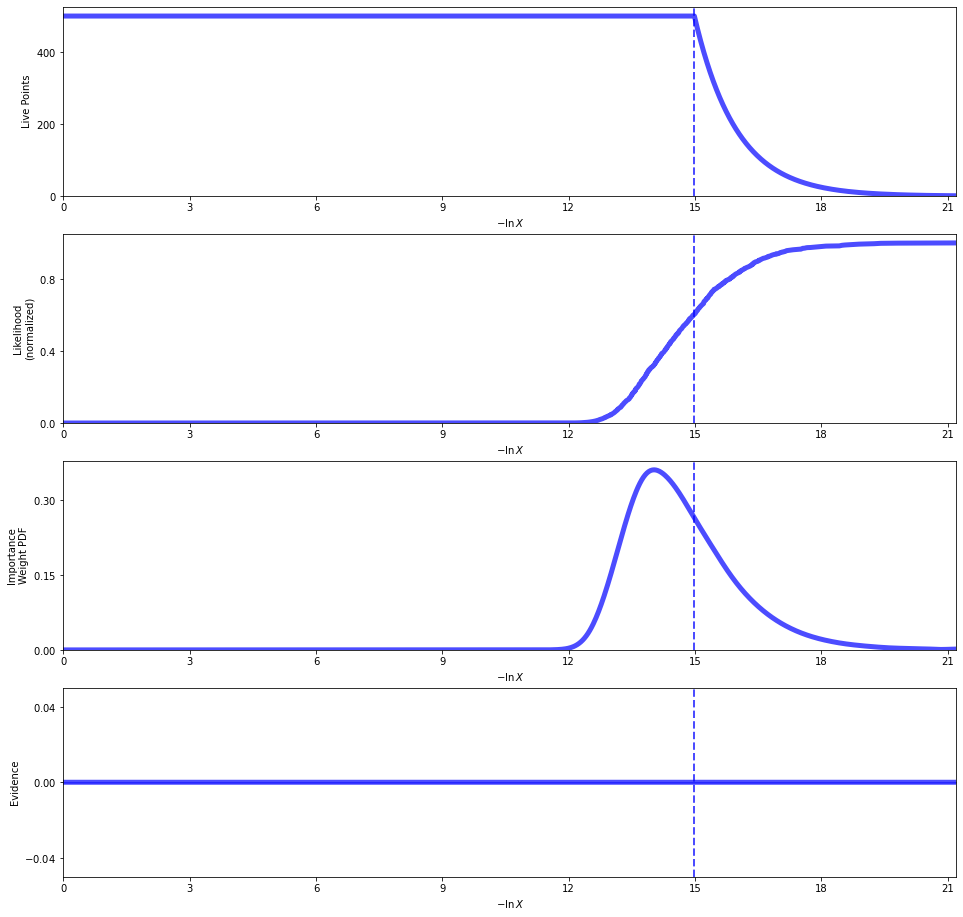

In [76]:
# Plot a summary of the run.
rfig, raxes = dynesty.plotting.runplot(results)

The Evidence panel appears to be utterly unhelpful in this case (at least when I ran it), so below is a plot of the log-evidence as a function of iteration, discarding the beginning when the accumulated evidence is truly tiny. It should show us converging to a value similar to what we found earlier.

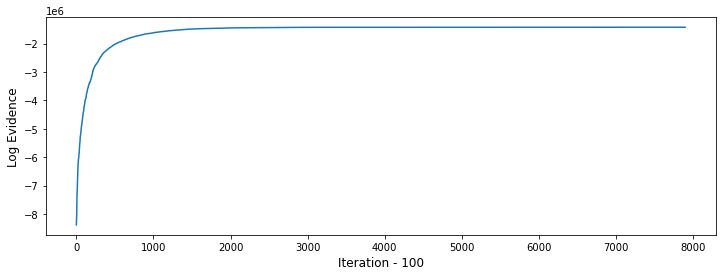

In [77]:
plt.rcParams['figure.figsize'] = (12.0, 4.0)
Ndiscard = 100
plt.plot(results['logz'][Ndiscard:]);
plt.xlabel("Iteration - "+str(Ndiscard), fontsize=12);
plt.ylabel("Log Evidence", fontsize=12);

This extracts the log-evidence at the last iteration, which may or not be the approved method.

In [78]:
results['logz'][-1]

-1423202.5366907148

Let's compare with what we got from simple monte carlo:

In [79]:
logE1 - results['logz'][-1]

1422376.7854481372

That was so easy, let's go ahead and do the same for Model 2. Implement the transformation from the unit cube to your model's parameter space:

And run this elegant definition:

In [80]:
def dyn_log_like2(params):
    return Model2.log_likelihood(*params)

Now we can go ahead and run the sample.

In [82]:
%%time
sampler = dynesty.NestedSampler(dyn_log_like2, ptform, len(Model2.param_names))
sampler.run_nested()
results = sampler.results

2893it [00:07, 406.93it/s, +500 | bound: 3 | nc: 1 | ncall: 19944 | eff(%): 17.450 | loglstar:   -inf < -1243.491 <    inf | logz: -1248.427 +/-  0.088 | dlogz:  0.001 >  0.509]

CPU times: user 7.22 s, sys: 0 ns, total: 7.22 s
Wall time: 7.21 s


... and produce the same set of plots.

/home/ohj/.local/lib/python3.10/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


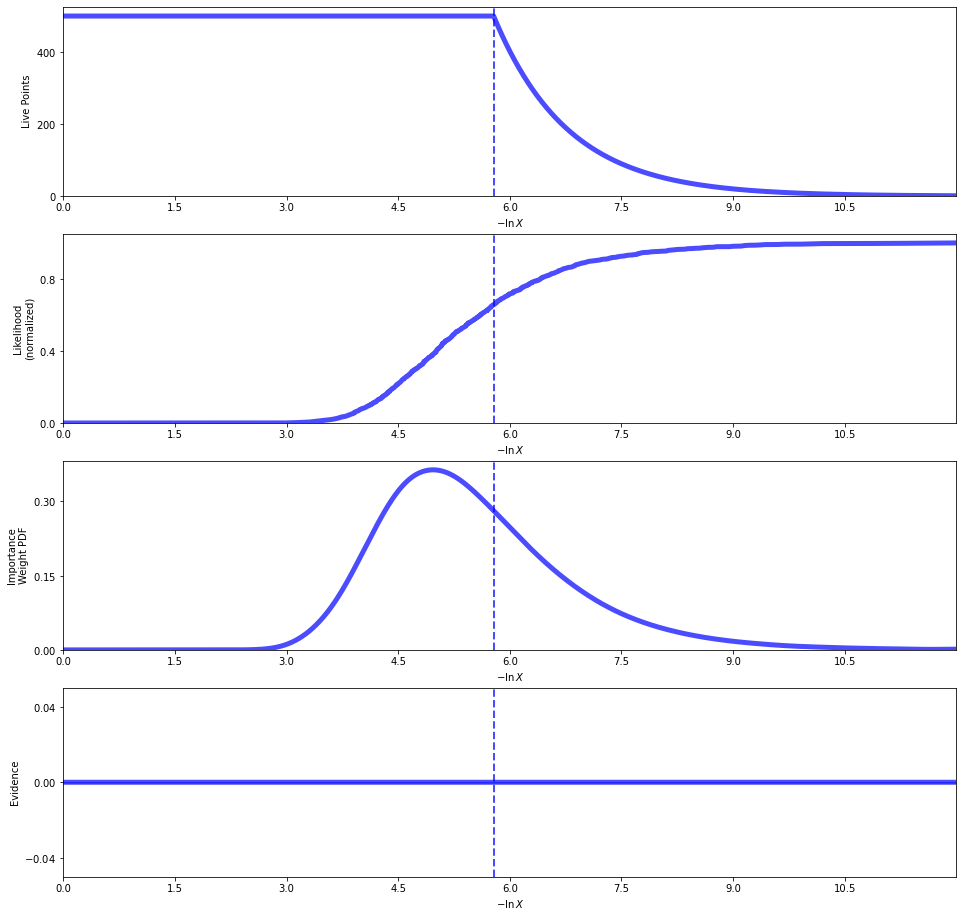

In [83]:
rfig, raxes = dynesty.plotting.runplot(results)

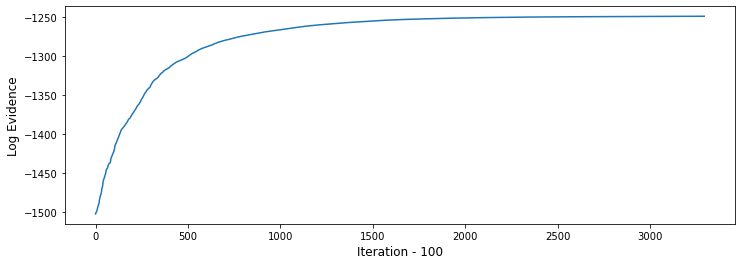

In [84]:
plt.rcParams['figure.figsize'] = (12.0, 4.0)
Ndiscard = 100
plt.plot(results['logz'][Ndiscard:]);
plt.xlabel("Iteration - "+str(Ndiscard), fontsize=12);
plt.ylabel("Log Evidence", fontsize=12);

Finally, extract the final evidence,

In [85]:
results['logz'][-1]

-1248.4271760811307

... and compare it to the SMC result.

In [86]:
logE2 - results['logz'][-1]

359.00481731565424

Given the work you'd already done, that was (I hope) staggeringly easy to set up, even if it did take longer to compute the same answer (I find) in this case. In larger-dimensional parameter spaces, it's easy to imagine this method being far preferable to blindly sampling from the prior. Note that we run `dynesty` out of the box here - there are many options (and some potential failure modes) that you should read about before using it in the real world.